In [401]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, mkdir
from os.path import isfile, join, exists
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
def gauss_compress_step(img):
    return cv.GaussianBlur(img, (5,5), 0)[::2, ::2, :].clip(0, 255).astype(np.uint8)

In [3]:
def compress_image(img):
    return gauss_compress_step(gauss_compress_step(img))

In [4]:
def show_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [5]:
def compress_all_jpg_in_directory(path):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    result_path = path + "_compress"
    if not exists(result_path):
        mkdir(result_path)
        
    for num, filename in enumerate(onlyfiles):
        img = cv.imread(path + "/" + filename)
        name = "pict_" + str(num) + ".png"
        compress_img = compress_image(img)
        cv.imwrite(result_path + "/" + name, compress_img)   

In [6]:
def draw_matches(img_first, img_second, callable_descriptor):
    keypoints_first, descriptors_first = callable_descriptor(img_first)
    keypoints_second, descriptors_second = callable_descriptor(img_second)
    draw_matches_tech(img_first, keypoints_first, descriptors_first,
                      img_second, keypoints_second, descriptors_second)

In [7]:
def draw_matches_tech(img_first, keypoints_first, descriptor_first, 
                 img_second, keypoints_second, descriptor_second):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

    matches = bf.match(descriptor_first, descriptor_second)
    matches = sorted(matches, key = lambda x:x.distance)    
    img3 = cv.drawMatches(img_first, keypoints_first, img_second, keypoints_second, matches[:], img_second, flags=2)
    plt.imshow(img3)
    plt.show()

In [8]:
def match_accuracy(matches, count_all_features):
    first_set_idx = [matches[i].trainIdx for i in range(len(matches))]
    second_set_idx = [matches[i].queryIdx for i in range(len(matches))]
    first_set_count_features = len(set(first_set_idx))
    second_set_count_features = len(set(second_set_idx))
    
    return (first_set_count_features + second_set_count_features) / count_all_features    

In [9]:
def match_mean_distance(matches):
    return np.mean([matches[i].distance for i in range(len(matches))])

In [10]:
def calc_SIFT(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [11]:
def calc_AKAZE(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.AKAZE_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [12]:
def calc_BRISK(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.BRISK_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [13]:
def calc_process_images(origin_image, list_of_images, callback_descriptor, descriptor_name):
    origin_keypoints, origin_descriptors = callback_descriptor(origin_image)
    result_metrics = []
    if descriptor_name in ['SIFT', 'AKAZE']:
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    elif descriptor_name == 'BRISK':
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    for current_image in list_of_images:
        start_time = time.time()
        
        current_keypoints, current_descriptors = callback_descriptor(current_image[0])
        matches = bf.match(origin_descriptors, current_descriptors)
        
        curr_time = time.time() - start_time
        
        accury = match_accuracy(matches, len(origin_keypoints) + len(current_keypoints))
        mean_distance = match_mean_distance(matches)
        result_metrics.append((accury, mean_distance, curr_time, current_image[0]))
    
    return result_metrics

In [191]:
def prepare_data(path, need_compress=False):
    if need_compress:
        compress_all_jpg_in_directory(path)
        path = path + "_compress"
        
    
    list_of_images = []
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for im in images:
        current_image = cv.imread(path + "/" + im)
        list_of_images.append(current_image)
    
    return list_of_images

In [192]:
def main_process(descriptor_name, path_to_folder_with_images, path_to_origin_image, need_to_compress):
    #ну тут нужно харкодить))
    name_to_desc = {'SIFT': calc_SIFT, 'AKAZE': calc_AKAZE, 'BRISK': calc_BRISK}
    origin_image = cv.imread(path_to_origin_image)
    
    return calc_process_images(origin_image, prepare_data(path_to_folder_with_images, need_to_compress),
                               name_to_desc[descriptor_name], descriptor_name)

In [193]:
def draw_results(metrics_result, descriptor_name, origin_image):
    n = len(metrics_result)
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    y = [metrics_result[i][0] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('match accuracy')
    plt.xlabel('number of sample')
    plt.ylabel('accuracy')
    
    plt.subplot(1, 3, 2)
    y = [metrics_result[i][1] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('mean distance')
    plt.xlabel('number of sample')
    plt.ylabel('distance')
    
    plt.subplot(1, 3, 3)
    y = [metrics_result[i][2] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('time')
    plt.xlabel('number of sample')
    plt.ylabel('time')
    
    plt.show()

Будем обучать наш классификатор уже на привычном нам объекте:

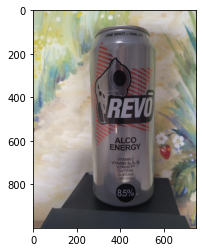

In [194]:
show_image(cv.imread('dataset1/original_picture.png'))

Для начала соберем наш датасет, который будет состоять из фотографий с тремя видами предметов. 
Мы зададимся себе целью классифицировать наш предмет на фотографии, либо его отсутствие -- то есть мы имеем дело
с бинарной классификаций.


Фотографии с нашим объектом:

In [195]:
picture_with_object = prepare_data('dataset1/dataset1_compress', False)

print('Count picture with object:', len(picture_with_object))

Count picture with object: 113


Фотографии без нашего объекта:

In [196]:
picture_without_object = prepare_data('dataset2/dataset2_compress', False)
picture_without_object.extend(prepare_data('dataset3/dataset3_compress', False))

print('Count picture without object', len(picture_without_object))

Count picture without object 210


Теперь соберем общий датасет 

In [197]:
data = picture_with_object + picture_without_object
y = np.hstack([np.ones(len(picture_with_object)), np.zeros(len(picture_without_object))])

Разобьем на train и test (test - 25%). Заметим, что данные у нас упорядоченные, но train_test_split делает случайное разделение выборки.

In [198]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

Как видим выборка успешно перемешалась:

In [199]:
print(y_train[0:20])

[0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.]


Далее что бы работать с классификацией, нам необходимо преобразование, которые делает из картинки вектор. Для этого воспользуем методом bag of words, который будет работать с произвольным дескриптором.


Кратко опишем метод bag of words. У нас имеется train выборка, посчитаем для каждого изображения выбранный
дескриптор, получим некий набор дескрипторов для данного изображение. Собираем все дескрипторные описания каждого
изображение вместе, применяем K-means, и получаем k-центров кластеров. И далее, чтобы получить **k-мерное представления**
изображения строим нормированную диаграмму принадлежности каждого дескрипторного описания к некому кластеру.

In [184]:
print(type(data[0][1]))

<class 'str'>


In [205]:
def fit_bag_of_words(data, callable_descriptor):
    all_descriptors = []
    for idx, current_image in enumerate(data):
        keypoints, descriptors = callable_descriptor(current_image)
        all_descriptors.extend(descriptors)
    
    # count of clusters
    k = 50
    kmeans = KMeans(n_clusters=k, verbose=False).fit(all_descriptors)
    
    return kmeans

Обучим bag of words на train выборке используя дескриптор SIFT, BRISK и AKAZE

In [219]:
k_means_train_sift = fit_bag_of_words(x_train, calc_SIFT)

In [220]:
k_means_train_brisk = fit_bag_of_words(x_train, calc_BRISK)

In [221]:
k_means_train_akaze = fit_bag_of_words(x_train, calc_AKAZE)

Теперь чтобы уметь получать векторное k-мерное представление картинки, научимся считать нормированные диаграммы по уже обучененому K-means

In [208]:
def picture_to_vector(picture, k_means_pretrained, callable_descriptor, k_cluster=50):
    keypoints, descriptors = callable_descriptor(picture)
    histogram = np.zeros(k_cluster)
    kp_count = len(keypoints)
    
    for d in descriptors:
        idx = k_means_pretrained.predict([d])
        histogram[idx] += 1.0 / kp_count
        
    return histogram
    

Отлично, теперь мы умеем находить представление картинки в k-мерном пространстве в зависимости от дескриптора.

Теперь сформируем датасеты в векторном представлении картинок, и проведем эксперименты с классификаторами Quadratic classifier и Gaussian Process Classifier. Используем дескриптор SIFT

In [223]:
x_train_vec_sift = np.array([picture_to_vector(pic, k_means_train_sift, calc_SIFT) for pic in x_train])
x_test_vec_sift = np.array([picture_to_vector(pic, k_means_train_sift, calc_SIFT) for pic in x_test])

Теперь обучим классификаторы Quadratic classifier, Gaussian Process Classifier и Support Vector Classifier

In [450]:
quadratic_clf = QuadraticDiscriminantAnalysis()
gaussian_process_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
svc_clf = SVC(kernel="linear", C=0.025)

quadratic_clf.fit(x_train_vec_sift, y_train)
gaussian_process_clf.fit(x_train_vec_sift, y_train)
svc_clf.fit(x_train_vec_sift, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Теперь напишем функцию, которая делает предсказания на тестовой выборке, и считает accuracy, false-positive,
false-negative и время обработки тестового датасета.

In [451]:
def false_positive(y_true, y_pred):
    result = 0
    result_idx = []
    for i in range(len(y_true)):
        if y_pred[i] == 1 and y_true[i] == 0:
            result += 1
            result_idx.append(i)
    return result, result_idx

In [452]:
def false_negative(y_true, y_pred):
    result = 0
    result_idx = []
    for i in range(len(y_true)):
        if y_pred[i] == 0 and y_true[i] == 1:
            result += 1
            result_idx.append(i)
    return result, result_idx

In [453]:
class PredictResult:
    def __init__(self, accuracy, mean_time, false_negative_score, false_positive_score):
        self.accuracy = accuracy
        self.mean_time = mean_time
        self.false_negative_score = false_negative_score
        self.false_positive_score = false_positive_score
        
    def print_result(self):
        print('Accuracy =', self.accuracy)
        print('Mean time =', self.mean_time)
        print('False negative score =', self.false_negative_score)
        print('False positive score =', self.false_positive_score)

In [454]:
def predict_probability(pretrained_clf, x_test, y_true):
    start_time = time.time()
    #y_predict_proba = pretrained_clf.predict_proba(x_test_vec_sift)
    y_predict = pretrained_clf.predict(x_test)
    end_time = time.time() - start_time
    accuracy = accuracy_score(y_true, y_predict)
    mean_time = end_time / x_test.shape[0]
    false_negative_score = false_negative(y_true, y_predict)[0]
    false_positive_score = false_positive(y_true, y_predict)[0]
    
    return y_predict, PredictResult(accuracy, mean_time, false_negative_score, false_positive_score)

Теперь сделаем предсказания с помощью двух классификаторов и посмотрим на результаты:

In [467]:
quadratic_clf_pred, quadratic_result = predict_probability(quadratic_clf, x_test_vec_sift, y_test)
gaussian_process_clf_pred, gaussian_process_result = predict_probability(gaussian_process_clf, x_test_vec_sift, y_test)
svc_clf_pred, svc_result = predict_probability(svc_clf, x_test_vec_sift, y_test)

Посмотрим на результаты работы Quadratic classifier

In [468]:
quadratic_result.print_result()

Accuracy = 0.9506172839506173
Mean time = 2.2046359968774114e-05
False negative score = 4
False positive score = 0


Мы получили хорошую точность класификации, а учитывая, что у нас достаточно сбалансированые классы (банок ревок около трети всего датасета),
можно считать это надежным показателем качества модели. Также среднее время обработки одной картинки очень мало, что позволит обрабатывать большие объемы данных, но стоит заметит,ь что значительные вычислительные ресурсы трятатся на этапе получения векторного представления картинки. И мы получили 4 false negative результата, посмотрим на них.

In [469]:
false_negative_idx = false_negative(y_test, quadratic_clf_pred)[1]

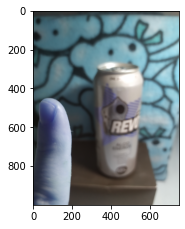

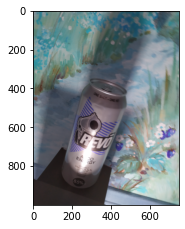

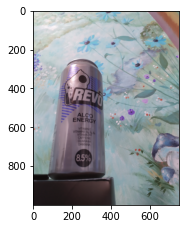

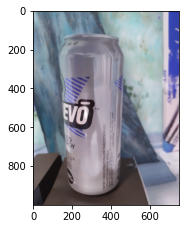

In [470]:
for i in range(len(false_negative_idx)):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    plt.imshow(x_test[false_negative_idx[i]])

Как видим на этих картинках наш классификатор идентифицирует ложное отсутствие предмета. Зато мы не имеем ни одного ложно положительного срабатывания.

Посмотрим на результаты работы Gaussian Process Classifier

In [471]:
gaussian_process_result.print_result()

Accuracy = 0.9753086419753086
Mean time = 3.716386394736207e-05
False negative score = 1
False positive score = 1


Как видим, мы имеем так же достаточно хорошее качество, и сравнительно маленькое время обработки изображения. Мы получили 1 ложно положительное срабатывание и 1 ложно отрицательное.

Посмотрим на ложно положительный результат:

In [472]:
false_positive_idx = false_positive(y_test, gaussian_process_clf_pred)[1]

In [473]:
print(gaussian_process_clf_pred[1])

0.0


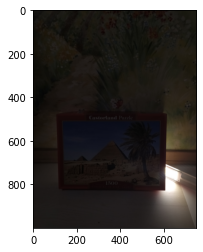

In [474]:
show_image(x_test[false_positive_idx[0]])

И в правду, это чем-то напоминает банку рево.

Ложно отрицательное срабатывание:

In [475]:
false_negative_idx = false_negative(y_test, gaussian_process_clf_pred)[1]

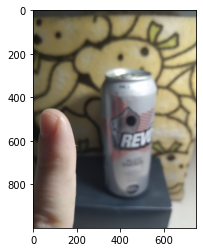

In [476]:
show_image(x_test[false_negative_idx[0]])

И посмотрим на результаты Supper Vector Classifier

In [477]:
svc_result.print_result()

Accuracy = 0.6172839506172839
Mean time = 4.814877922152295e-05
False negative score = 31
False positive score = 0


Как видим, SVC справился намного хуже, чем классификаторы Quadratic classifier и Gaussian Process Classifier. Скорее всего это обусловнено структурой пространста, и алгоритма связанным с гуссовскими распределения удалось более успешно восстановить зависимость.

Посмотрим на несколько false-negative результатов:

In [478]:
false_negative_idx = false_negative(y_test, svc_clf_pred)[1]

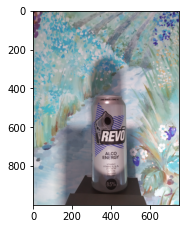

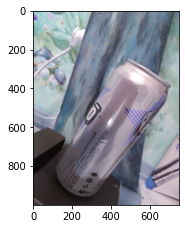

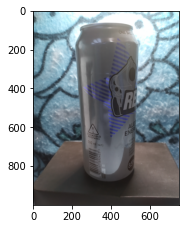

In [479]:
for i in range(3):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    plt.imshow(x_test[false_negative_idx[i]])

Там, где мы без проблем узнаем старую любимую банку рево, наш алгоритм SVC ошибается...

Можно сделать вывод, что для успешной классификации необходим рациональный подход к выбору и обучению классификатора. Что мы успешно и продемонстрировали в работе.

Теперь перейдем к части, где мы будем пытаться обнаружить наш предмет на видео.

Сначала напишем техническую функцию-генератор, которая будет обходить матрицу (изображение) скользящим окном заднного размера.

In [40]:
def correct_slice(current_x, current_y, x_size, y_size, matrix_shape):
    return (current_x + x_size - 1 < matrix_shape[0]) and (current_y + y_size - 1 < matrix_shape[1])

def sliding_window(mtx, x_size, y_size, dx_step, dy_step):
    current_x, current_y = (0, 0)
    while True:
        if not correct_slice(current_x, current_y, x_size, y_size, mtx.shape):
            break
        
        yield current_x, current_y, mtx[current_x: current_x + x_size, current_y: current_y + y_size]
        
        if current_x + dx_step  < mtx.shape[0] and correct_slice(current_x + dx_step, current_y, x_size, y_size, mtx.shape):
            current_x += dx_step
        elif current_y + dy_step < mtx.shape[1] and correct_slice(current_x, current_y + dy_step, x_size, y_size, mtx.shape):
            current_x = 0
            current_y += dy_step
        else:
            break

In [41]:
def gauss_filter(img):
    return cv.GaussianBlur(img, (5,5), 0).clip(0, 255).astype(np.uint8)

Опишем процесс детекции предмета на видео. Очевидно, видео разбивается на кадры и детекцию проводим в пределах каждого кадра. Кадр мы обходим скользящим окном, и на скользящее окно смотрим как на новое изображение на котором мы и будем искать банку рево. Используя ранее обученный bag of words переводим это изображение (скользящее окно) в векторное представление и с помощью ранее обученного классификатора предсказываем принадлежность нашому классу. И среди всех таких скользящих окном выбираем то, где принадлежность к нашему классу максимальная, и по контурам этого окна рисуем прямоугольник, таким образом получаем детекцию предмета на видео.

In [ ]:
cap = cv.VideoCapture('video_test.mp4')
full_hd_shape = (1920, 1080)
vid = cv.VideoWriter('out.mp4', cv.VideoWriter_fourcc(*'mp4v'), 24, full_hd_shape, True)

sliding_window_sizes = [(250, 800), (800, 250)]
step_dx = full_hd_shape[1] // 5
step_dy = full_hd_shape[0] // 5

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        best_proba = 0
        best_curr_x, best_curr_y = None, None
        best_sl_size = None, None
        frame = gauss_filter(frame)
        for sliding_window_size in sliding_window_sizes:
            for curr_x, curr_y, subwindow in sliding_window(frame, *sliding_window_size, step_dx, step_dy):
                try:
                    subwindow_vector_representation = picture_to_vector(subwindow, k_means_train_sift, calc_SIFT)
                    pred_proba = gaussian_process_clf.predict_proba([subwindow_vector_representation])[0][1]
                    if pred_proba > 0.5:
                        if pred_proba > best_proba:
                            best_proba = pred_proba
                            best_curr_x, best_curr_y = curr_x, curr_y
                            best_sl_size = sliding_window_size
                except:
                    print("incorrect frame")
        
        if best_proba > 0:
            cv.rectangle(frame, 
                         (best_curr_y, best_curr_x), 
                         (best_curr_y + best_sl_size[1], best_curr_x + best_sl_size[0]), 
                         (255, 0, 0), 5) 
                    
        vid.write(frame)
    else:
        break

vid.release()
cap.release()
cv.destroyAllWindows()

Запись уже обработаго видео, так как и датасет с картинка можно найти тут:

https://drive.google.com/drive/folders/1U8o1edLtNn6z-ix0pugcpDMRbQejrpMi?usp=sharing